In [1]:
import matplotlib.pyplot as plt
from AaltoAtoms import CircCorralData, CircCorral
from AMRL import Createc_Controller
from AMRL.Environment.get_atom_coordinate import pixel_to_nm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import ipywidgets as wdg

## Get the current scan frame from the STM, get atom positions using Gaussian fits, and program lateral manipulation moves (in order of their labeling in the figure) using GUI. 
This may require fine-tuning the parameters 'percentile' and 'edge_cutoff' in the C.get_region_centroids() call until only the surface features you want to see are registered in the image frame when you run the cell.

succeed to connect
	23 centroids


<IPython.core.display.Javascript object>


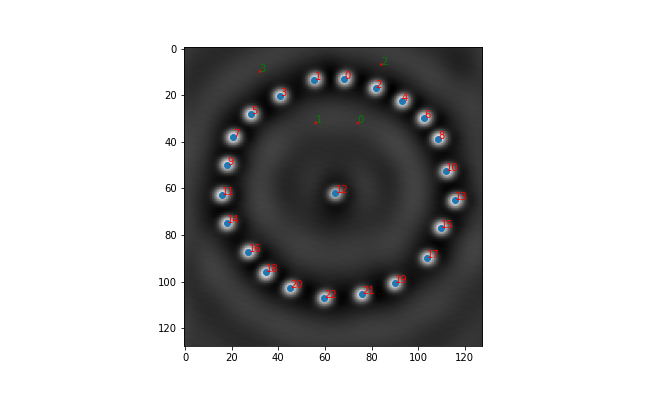

Textarea(value='[]', description='points:')

In [259]:
%matplotlib notebook

CC = Createc_Controller()

# f = r"Y:\labdata\Createc\STMDATA\Ag(111)\2022-03 Co Kondo corrals\04-04\A220405.101017.dat"
# C = CircCorralData(f, "label")
# C.occupied = True
# C.corral = True
# C.get_region_centroids()
# 

Cim = np.array(CC.stm.scandata(1,4))
zconst = float(CC.stm.getparam('ZPiezoConst'))
nmx = nmy = CC.get_len_nm()
C = CircCorral(Cim, zconst, nmx, nmy)
C.subtract_plane()
C.get_region_centroids(percentile=99, edge_cutoff=0.1, show=False)

# scale numbers between 0 and 1
# the image has to have 3 channels
# in this case we will just repeat the same channel 3 times
im = MinMaxScaler().fit_transform(Cim.flatten().reshape(-1, 1)).reshape(Cim.shape)
dispmat = np.stack([im,im,im], axis=-1)

fig = plt.figure()
plt.imshow(dispmat)

# show the atom positions
plt.scatter(*np.array(C.centroids).T)

# give numbers to atom positions
for n, c in enumerate(C.centroids):
    plt.text(*c,'%d' %(n), color='r')

# List for selected pixels
selected = []
index = 0

# Create a text area for displaying selected pixels
text_area = wdg.Textarea(
    value = str(selected),
    description = "points:",
    disabled = False
)
display(text_area)

# Function to run when a pixel is clicked
def onclick(event):
    ''' Add the clicked pixel to the list of selected pixels and
    display it as red in the image.
    '''
    global selected
    global index
    x = int(event.xdata+0.5)
    y = int(event.ydata+0.5)
    if (y, x) in selected:
        im[y,x] = C.im[y,x]
        dispmat[y,x,:] = [im[y,x], im[y,x], im[y,x]]
        selected.remove((y, x))
    else:
        dispmat[y,x,:] = [1,0,0]
        selected += [(y, x)]
    text_area.value = str(selected)  # str(dir(event))
    print(selected)
    plt.imshow(dispmat)
    plt.text(x,y,'%d' %(index), color='green')
    index += 1
    fig.canvas.draw()

ka = fig.canvas.mpl_connect('button_press_event', onclick)

### Show atom positions from scan frame and programmed lateral manipulations. 
If they are wrong, run the previous Jupyter notebook cell again and program the lateral manipulations again using the GUI.

	Max height guess different from Gaussian fit on average by: 0.94 Å
	 2022-04-07 16:28:52.742428
	Central atom from Naive fit:  5.979150018300402 [65.04076597 60.08774157]
	Central atom from Gauss fit:  5.986183091805668 [65.60404405 60.54266201]


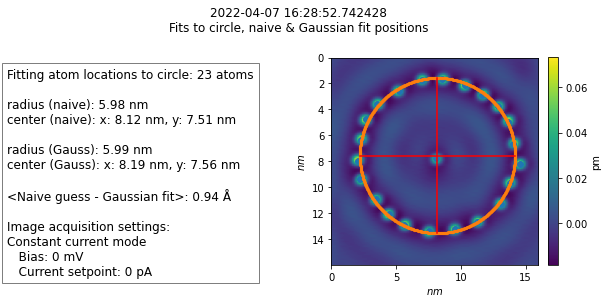

5.986183091805668

In [4]:
%matplotlib inline
C.occupied = True
C.get_corral_radius(1, savefig=False)

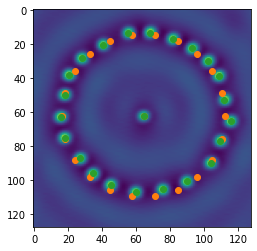

In [218]:
%matplotlib inline

n_wall_atoms = len(C.centroids) - 1
center = C.get_central_atom(C.centroids)

radius = 6
perfect_circle = np.array([[radius*np.cos(t), radius*np.sin(t)] for t in np.arange(0, 2*np.pi, 2*np.pi/(n_wall_atoms))])
perfect_circle = np.concatenate((perfect_circle, [[0,0]]))
perfect_circle = list(map(C.nm_to_pix, perfect_circle))
perfect_circle += np.array(center)

assert(len(perfect_circle)==len(C.centroids))

plt.imshow(C.im);
plt.scatter(*center)
plt.scatter(*(np.array(perfect_circle).T))
plt.scatter(*np.array(C.centroids).T)
plt.show()

In [236]:
import math
refvec = [0, 1]

def clockwiseangle(point, origin):
    # Vector between point and the origin: v = p - o
    vector = [point[0]-origin[0], point[1]-origin[1]]
    # Length of vector: ||v||
    lenvector = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if lenvector == 0:
        print("zero vector")
        return 2*np.pi
    # Normalize vector: v/||v||
    normalized = [vector[0]/lenvector, vector[1]/lenvector]
    dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
    diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
    angle = math.atan2(diffprod, dotprod)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    #if angle < 0:
     #   return 2*math.pi+angle
    # I return first the angle because that's the primary sorting criterium
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle

zero vector
55.5 13.5 [53.10020709 15.33864013]
40.8 20.4 [40.41595458 20.44044586]
28.125 28.125 [29.6828482  28.90915951]
20.66666666666667 38.111111111111114 [21.77042039 40.05869626]
18.125 49.875 [17.31968899 52.98578695]
15.875 62.875 [16.69122581 66.64315557]
18.0 75.0 [19.93594517 79.92436333]
27.125 87.125 [26.79097923 91.75344579]
34.666666666666664 96.11111111111111 [ 36.70097389 101.17208101]
45.0 102.71428571428571 [ 48.86308031 107.4172272 ]
59.714285714285715 107.0 [ 62.29199697 109.98293974]
75.83333333333333 105.16666666666667 [ 75.89979291 108.66135987]
90.0 100.71428571428571 [ 88.58404542 103.55955414]
103.875 89.875 [99.3171518  95.09084049]
109.66666666666667 76.88888888888889 [107.22957961  83.94130374]
115.66666666666667 65.11111111111111 [111.68031101  71.01421305]
112.0 52.714285714285715 [112.30877419  57.35684443]
108.66666666666667 38.888888888888886 [109.06405483  44.07563667]
102.5 30.0 [102.20902077  32.24655421]
93.0 22.5 [92.29902611 22.82791899]
81.71

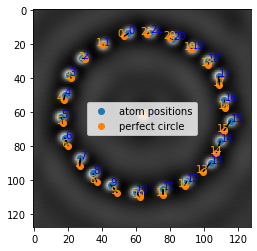

array([-1.94000789,  2.47102687,  0.        ])

In [247]:
# Kabsch algorithm for the best rotation between two sets to minimize distance
from scipy.spatial.transform import Rotation

# create 3D arrays to align vectors using algorithm
# subtract the center
centroids_3D = np.array(C.centroids) - np.array(center)

# need to order centroids in same order as perfect circle to make Kabsch algo work
clockwise_angle = lambda point: clockwiseangle(point, [0,0])
centroids_3D = np.array(sorted(centroids_3D, key=clockwise_angle))

perfect_circle_3D = np.array(perfect_circle) - np.array(center)

centroids_3D = np.append(centroids_3D.T, [np.zeros(len(C.centroids)).T], axis=0).T
perfect_circle_3D = np.append(perfect_circle_3D.T, [np.zeros(len(C.centroids)).T], axis=0).T

R, rmsd_ = Rotation.align_vectors(centroids_3D, perfect_circle_3D)

applied_rotation = R.apply(perfect_circle_3D)[:,0:2].T
applied_rotation = [x + center for x in applied_rotation.T]

centroids_3D = np.array([c + center for c in centroids_3D[:,0:2]])


plt.imshow(dispmat);

plt.scatter(*np.array(centroids_3D).T, label="atom positions")
plt.scatter(*np.array(applied_rotation).T, label="perfect circle")
plt.legend()

for n,c in enumerate(centroids_3D):
    print(*centroids_3D[:][n], applied_rotation[n])
    initial = pixel_to_nm(centroids_3D[:,][n], dispmat, offset_nm, [len_nm, len_nm])
    
    final = pixel_to_nm(np.array(applied_rotation[n]).T, dispmat[:,:,0], offset_nm, [len_nm, len_nm])
    
    dx, dy = (np.array(applied_rotation[n]) - np.array(centroids_3D[n]))
    
    plt.text(*c,'%d' %(n), color='blue')
    plt.text(*(applied_rotation[n]-[4,0]),'%d' %(n), color='orange')

    plt.arrow(*centroids_3D[n], dx, dy)
plt.show()

#np.dot(R.as_matrix(), perfect_circle_3D)

## Show the atoms and where you are programming them to go

IndexError: list index out of range

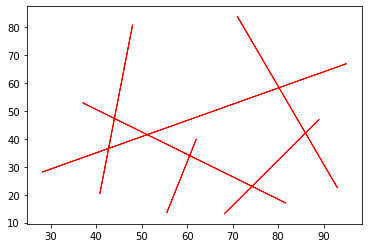

In [255]:
%matplotlib inline
#assert(len(selected)==len(C.centroids))
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()
selected1 = selected
centroids = C.centroids

for n, c in enumerate(C.centroids):
    plt.arrow(*c, *(np.array(list(reversed(selected[n])))-np.array(c)), color="r")
plt.imshow(dispmat);
plt.show()
#

## Program the lateral manipulation parameters and carry out the lateral manipulations in order 

In [251]:
# set the lateral manipulation parameters
latman_millivolt = 2
latman_picoamp = 60000

# for each "atom" in the image
for n in range(len(centroids)):
    print(centroids[n], list(reversed(selected1[n])))
    initial = pixel_to_nm(centroids[n], dispmat, offset_nm, [len_nm, len_nm])
    final = pixel_to_nm(np.array(list(reversed(selected1[n]))), dispmat[:,:,0], offset_nm, [len_nm, len_nm])
    plt.imshow(dispmat);
    plt.arrow(*centroids[n], *(np.array(list(reversed(selected[n])))-np.array(centroids[n])))
    plt.show()
    
    # see documentation in AMRL/Environment/createc_control.py
    latmandata = CC.lat_manipulation(*initial, *final, latman_millivolt, latman_picoamp, offset_nm, nmx)

IndexError: list index out of range

In [250]:
# the units of this is unknown ? 
plt.plot(latmandata.y)

NameError: name 'latmandata' is not defined